<a href="https://colab.research.google.com/github/NotYC/ML-integrated-CreditScoring/blob/main/MICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# STEP 1: UPLOAD FILE MANUALLY
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

# Automatically read the first uploaded file
df = pd.read_csv(io.BytesIO(next(iter(uploaded.values()))))
df.head()

Saving synthetic_credit_data.csv to synthetic_credit_data.csv


,Age,Income,Employment_Status,Education_Level,Marital_Status,Number_of_Dependents,Credit_Utilization_Ratio,Missed_Payments_90days,Total_Credit_Accounts,Debt_to_Income_Ratio,Length_of_Credit_History,Bankruptcies,Credit_Score
0,58,141379.94,Unemployed,High School,Single,0,33.80,4,10,51.50,1.4,0,300.00
1,48,20979.47,Self-Employed,High School,Divorced,3,54.97,4,9,48.95,3.1,0,300.00
2,34,49293.26,Self-Employed,PhD,Single,0,79.16,4,11,32.97,12.6,0,619.43
3,62,67496.39,Unemployed,Master,Single,1,21.93,0,10,17.81,16.6,0,850.00
4,27,83415.27,Retired,Bachelor,Married,1,34.24,2,1,51.49,6.4,1,300.00


In [3]:
# STEP 2: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import VotingRegressor


In [5]:
# STEP 4: PREPROCESSING

# Drop rows with too many missing values (optional)
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# Fill missing values for numeric columns with median
for col in df.select_dtypes(include='number').columns:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Fill missing values for categorical columns with mode
for col in df.select_dtypes(include='object').columns:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

# Encode categorical variables using LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Standardize the features
from sklearn.preprocessing import StandardScaler

X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [6]:
# STEP 5: TRAIN MODELS

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


In [7]:
# STEP 6: AVERAGE ENSEMBLE
final_pred = (lr_pred + xgb_pred) / 2


In [8]:
# STEP 7: CONVERT CONTINUOUS SCORE INTO CATEGORIES

def categorize(score):
    if score < 580:
        return 'Poor'
    elif score < 670:
        return 'Fair'
    elif score < 740:
        return 'Good'
    elif score < 800:
        return 'Very Good'
    else:
        return 'Excellent'

y_test_cat = y_test.apply(categorize)
final_pred_cat = pd.Series(final_pred).apply(categorize)


In [10]:
# Drop rows with too many missing values (optional)
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# Fill missing values for numeric columns with median
for col in df.select_dtypes(include='number').columns:
    df[col] = df[col].fillna(df[col].median())

# Fill missing values for categorical columns with mode
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])


In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [12]:
# Optional: Only run this if 'Credit_Score' is continuous (e.g., 300–850)
def categorize(score):
    if score < 580:
        return 'Poor'
    elif score < 670:
        return 'Fair'
    elif score < 740:
        return 'Good'
    elif score < 800:
        return 'Very Good'
    else:
        return 'Excellent'

df['Credit_Score'] = df['Credit_Score'].apply(categorize)


In [13]:
target_le = LabelEncoder()
df['Credit_Score'] = target_le.fit_transform(df['Credit_Score'])  # 0 to N categories


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [15]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:05:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Axes: ylabel='count'>

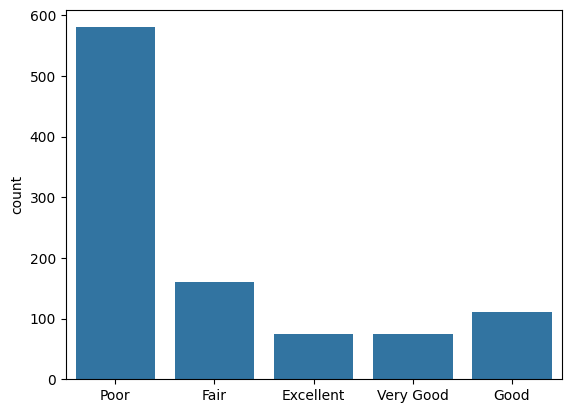

In [17]:
import seaborn as sns
sns.countplot(x=target_le.inverse_transform(y))


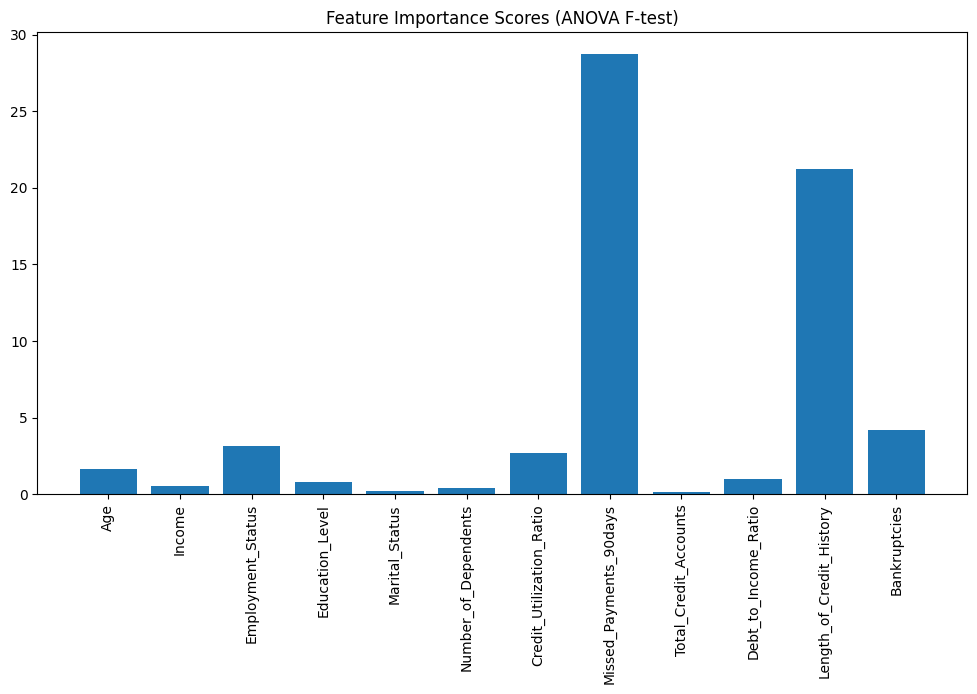

In [18]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Visualize feature importance
import matplotlib.pyplot as plt
feature_scores = selector.scores_
plt.figure(figsize=(12,6))
plt.bar(range(len(feature_scores)), feature_scores)
plt.xticks(ticks=range(len(X.columns)), labels=X.columns, rotation=90)
plt.title("Feature Importance Scores (ANOVA F-test)")
plt.show()
